<a href="https://colab.research.google.com/github/slp22/data-engineering-project/blob/main/engineering_monkeypox_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Data Engineering | Pipeline

# Monkeypox Tweets

## Imports

In [108]:
import json
import logging
import sqlite3
import matplotlib.pyplot as plt
import numpy as np
import os, shutil, itertools
import pandas as pd
import pathlib as Path
import pickle
import PIL
import random
import seaborn as sns
import sklearn as sk
import warnings
import zipfile


import nltk
import re
import en_core_web_sm
import string
pd.set_option('display.max_colwidth', None)
nltk.download('stopwords')

from nltk.tokenize import word_tokenize
from sklearn.decomposition import PCA, NMF
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

from wordcloud import WordCloud, STOPWORDS


from sqlite3 import connect
import time
from datetime import datetime
from dateutil.parser import parse
from dateutil.relativedelta import *
from dateutil.easter import *
from dateutil.rrule import *
from dateutil.parser import *
from datetime import *


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Google Drive

In [ ]:
# mount drive
from google.colab import drive
drive.mount('/content/drive')

# https://colab.research.google.com/notebooks/snippets/sheets.ipynb#scrollTo=JiJVCmu3dhFa

# authorize access 
from google.colab import auth
auth.authenticate_user()

# read in from Google Sheets

import gspread
from google.auth import default
creds, _ = default()

gc = gspread.authorize(creds)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Pyspark



In [ ]:
# # https://towardsdatascience.com/pyspark-on-google-colab-101-d31830b238be
# # https://www.analyticsvidhya.com/blog/2020/11/a-must-read-guide-on-how-to-work-with-pyspark-on-google-colab-for-data-scientists/

!apt-get install openjdk-8-jdk-headless -qq > /dev/null

In [ ]:
!wget -q https://archive.apache.org/dist/spark/spark-3.0.0/spark-3.0.0-bin-hadoop3.2.tgz

In [ ]:
!tar -xf spark-3.0.0-bin-hadoop3.2.tgz

In [ ]:
!pip install -q findspark

In [ ]:
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.0-bin-hadoop3.2"

In [ ]:
import findspark
findspark.init()

In [ ]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import split, explode, col, lower
from pyspark.sql.types import StructType,StructField, StringType, IntegerType


In [ ]:
! pip install geopandas

## 1 | Pipeline Design


* **Business Problem:** Can we build a dashboard to monitor top trending topics on Twitter about monkeypox?
* **Data source:** [Kaggle Tweets on Monkeypox ](https://www.kaggle.com/datasets/thakurnirmalya/monkeypox2022tweets)
* **Impact Hypothesis:** 

## 2 | Data Ingestion

#### 2.1  [Twitter Dataset on the 2022 MonkeyPox Outbreak](https://www.kaggle.com/datasets/thakurnirmalya/monkeypox2022tweets) 
* Dataset is list of TweetIDs

#### 2.2  [Twitter Hydrating](https://towardsdatascience.com/learn-how-to-easily-hydrate-tweets-a0f393ed340e#:~:text=Hydrating%20Tweets) with [DocNow Hydrator](https://github.com/DocNow/hydrator/releases)
* Processed on local machine
* Save to Google Sheets

#### 2.3  Import [hydrated tweets](https://drive.google.com/drive/folders/1NbddxuSF3v5YuOgjvA1G4WgfPUlKfiul?usp=sharing) from GoogleDrive to Colab
* Six Google Sheets of data

## 3 | Exploratory Data Analysis

### 3.1  Explore one set: `tweets` (n = 12,656) 

In [ ]:
w = ['TweetIDs_Part1', 'TweetIDs_Part2', 'TweetIDs_Part3', 'TweetIDs_Part4', 'TweetIDs_Part5', 'TweetIDs_Part6']
tweets = pd.DataFrame.from_records(gc.open(w[0]).sheet1.get_all_values())

In [ ]:
tweets.head(2)

,0,1,2,3,4,5,6,7,8,9,...,25,26,27,28,29,30,31,32,33,34
0,coordinates,created_at,hashtags,media,urls,favorite_count,id,in_reply_to_screen_name,in_reply_to_status_id,in_reply_to_user_id,...,user_followers_count,user_friends_count,user_listed_count,user_location,user_name,user_screen_name,user_statuses_count,user_time_zone,user_urls,user_verified
1,,Wed May 18 21:49:25 +0000 2022,,,,1,1527043704967528453,theofficepirate,1527043356878155776,140472501,...,36791,6088,255,,Yates,Jyates5,36441,,,FALSE


In [ ]:
tweets.columns = tweets.iloc[0]
tweets = tweets.drop(index=tweets.index[0])

In [ ]:
tweets.head(2)

,coordinates,created_at,hashtags,media,urls,favorite_count,id,in_reply_to_screen_name,in_reply_to_status_id,in_reply_to_user_id,...,user_followers_count,user_friends_count,user_listed_count,user_location,user_name,user_screen_name,user_statuses_count,user_time_zone,user_urls,user_verified
1,,Wed May 18 21:49:25 +0000 2022,,,,1,1527043704967528453,theofficepirate,1527043356878155776,140472501,...,36791,6088,255,,Yates,Jyates5,36441,,,FALSE
2,,Fri May 20 20:43:44 +0000 2022,,,,0,1527751952448344065,,,,...,134,553,3,"Chicago, IL",Patrick,LeftistHank,10782,,,FALSE


In [ ]:
cols_list = list(tweets.columns)
cols_list

['coordinates',
 'created_at',
 'hashtags',
 'media',
 'urls',
 'favorite_count',
 'id',
 'in_reply_to_screen_name',
 'in_reply_to_status_id',
 'in_reply_to_user_id',
 'lang',
 'place',
 'possibly_sensitive',
 'quote_id',
 'retweet_count',
 'retweet_id',
 'retweet_screen_name',
 'source',
 'text',
 'tweet_url',
 'user_created_at',
 'user_id',
 'user_default_profile_image',
 'user_description',
 'user_favourites_count',
 'user_followers_count',
 'user_friends_count',
 'user_listed_count',
 'user_location',
 'user_name',
 'user_screen_name',
 'user_statuses_count',
 'user_time_zone',
 'user_urls',
 'user_verified']

In [ ]:
tweets['hashtags']
tweets['hashtags'].nunique()

528

In [ ]:
tweets['possibly_sensitive'][0:2]

1    
2    
Name: possibly_sensitive, dtype: object

In [ ]:
tweets['text']

1        @theofficepirate You bro remember them talking...
2            oh monkey POX? I thought you said monkey POGS
3        If I get monkey pox y’all gotta bring me the j...
4        Great, the initial Monkey pox symptoms read li...
5        @freidergeist @Cameo3D @pullenmyleg_ @Breaking...
                               ...                        
12652    @thecoastguy @TimNielsenDay Patent applied for...
12653               Ian Brown looks like he has monkey pox
12654    @SkyNews how tf are people contracting “monkey...
12655    @ConceptualJames We really need a legitimate l...
12656    What you mean “monkey pox”? https://t.co/lin02...
Name: text, Length: 12656, dtype: object

In [ ]:
tweets['tweet_url'][0:2]

1    https://twitter.com/Jyates5/status/15270437049...
2    https://twitter.com/LeftistHank/status/1527751...
Name: tweet_url, dtype: object

In [ ]:
tweets['lang'].nunique() #40

40

In [ ]:
tweets['lang'].unique()

array(['en', 'ja', 'fr', 'de', 'pl', 'nl', 'qme', 'und', 'da', 'in', 'ta',
       'pt', 'es', 'et', 'ar', 'ru', 'tl', 'el', 'zh', 'qht', 'fi', 'zxx',
       'cy', 'it', 'art', 'tr', 'ht', 'qst', 'ko', 'sr', 'iw', 'ml', 'ro',
       'bn', 'sv', 'hi', 'th', 'ca', 'lv', 'lang'], dtype=object)

In [ ]:
print('English entries:', (tweets[tweets["lang"] == 'en'].count())['lang'])

English entries: 12137


In [ ]:
tweets = tweets[tweets['lang'] == 'en']
tweets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12137 entries, 1 to 12656
Data columns (total 35 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   coordinates                 12137 non-null  object
 1   created_at                  12137 non-null  object
 2   hashtags                    12137 non-null  object
 3   media                       12137 non-null  object
 4   urls                        12137 non-null  object
 5   favorite_count              12137 non-null  object
 6   id                          12137 non-null  object
 7   in_reply_to_screen_name     12137 non-null  object
 8   in_reply_to_status_id       12137 non-null  object
 9   in_reply_to_user_id         12137 non-null  object
 10  lang                        12137 non-null  object
 11  place                       12137 non-null  object
 12  possibly_sensitive          12137 non-null  object
 13  quote_id                    12137 non-null  ob

In [ ]:
tweets['user_created_at']

1        Fri Apr 01 00:29:41 +0000 2011
2        Fri Apr 01 13:14:03 +0000 2022
3        Fri Apr 01 15:12:02 +0000 2011
4        Fri Apr 01 16:27:26 +0000 2011
5        Fri Apr 01 17:41:17 +0000 2016
                      ...              
12652    Wed Sep 30 18:20:38 +0000 2015
12653    Wed Sep 30 19:12:03 +0000 2020
12654    Wed Sep 30 22:42:35 +0000 2020
12655    Wed Sep 30 23:06:12 +0000 2009
12656    Wed Sep 30 23:38:29 +0000 2009
Name: user_created_at, Length: 12137, dtype: object

In [ ]:
tweets['date'] = pd.to_datetime(tweets['user_created_at'], 
                                  format='%a %b %d %H:%M:%S +0000 %Y', 
                                  errors='coerce').dt.date

In [ ]:
tweets[['date']]

,date
1,2011-04-01
2,2022-04-01
3,2011-04-01
4,2011-04-01
5,2016-04-01
...,...
12652,2015-09-30
12653,2020-09-30
12654,2020-09-30
12655,2009-09-30


In [ ]:
tweets['user_id']

1                  275288972
2        1509881738302001155
3                  275573209
4                  275604178
5         715957219972530180
                ...         
12652             3826370843
12653    1311383290688004097
12654    1311436211429543943
12655               78734566
12656               78741475
Name: user_id, Length: 12137, dtype: object

In [ ]:
tweets['user_location']
tweets['user_location'].nunique()

4319

In [ ]:
tweets['user_screen_name']

1                Jyates5
2            LeftistHank
3         MyNameIsRickyM
4           Just_sue_now
5             JackPaceSr
              ...       
12652    theoceanlawyers
12653          RolexCola
12654            DeeKno_
12655         ChipFranks
12656          moni_lisa
Name: user_screen_name, Length: 12137, dtype: object

In [ ]:
tweets = tweets[['date',
                 'user_screen_name',
                 'text',
                 'tweet_url',
                 'user_location',
                 'hashtags']]
tweets.head(2)

,date,user_screen_name,text,tweet_url,user_location,hashtags
1,2011-04-01,Jyates5,@theofficepirate You bro remember them talking...,https://twitter.com/Jyates5/status/15270437049...,,
2,2022-04-01,LeftistHank,oh monkey POX? I thought you said monkey POGS,https://twitter.com/LeftistHank/status/1527751...,"Chicago, IL",


In [ ]:
tweets = tweets.sort_values('date')
tweets.head(2)

,date,user_screen_name,text,tweet_url,user_location,hashtags
464,2006-12-15,tash,Sorry I can't come to work today I've got monk...,https://twitter.com/tash/status/15254387202871...,Earth,
2501,2007-01-08,BBCNews,Several monkeybox cases have been found in the...,https://twitter.com/BBCNews/status/15277393737...,London,


In [ ]:
# https://stackoverflow.com/questions/22898824/filtering-pandas-dataframes-on-dates
# https://stackoverflow.com/questions/5619489/troubleshooting-descriptor-date-requires-a-datetime-datetime-object-but-rec

tweets = tweets[(tweets['date'] > date(2022,1,1))] 
tweets

,date,user_screen_name,text,tweet_url,user_location,hashtags
5817,2022-01-02,JoelPau68848306,@JohannaSzabo1 @postblocksyndro @igfbss @Garet...,https://twitter.com/JoelPau68848306/status/152...,,
5820,2022-01-02,cosborne687,@CandiceBergenMP You are the problem . Did yo...,https://twitter.com/cosborne687/status/1527372...,"Nipissing, Ontario",
5821,2022-01-02,localpirate7,@FoxNews Tf is monkey pox. Just stop it,https://twitter.com/localpirate7/status/152705...,,
5818,2022-01-02,Charles10151978,So then when are we locking down and shutting ...,https://twitter.com/Charles10151978/status/152...,,
5816,2022-01-02,ORnBNBucksCrew,Ayo we’re going to need to change the name “mo...,https://twitter.com/ORnBNBucksCrew/status/1527...,🇺🇸,
...,...,...,...,...,...,...
1372,2022-05-20,USAF_Brat66,@hrkbenowen Don’t anyone be scared and jump to...,https://twitter.com/USAF_Brat66/status/1528100...,"Tennessee, USA",
1366,2022-05-20,iwillnotsubmit1,"WW3 is on the horizon, Covid-19, and Monkey Po...",https://twitter.com/iwillnotsubmit1/status/152...,"New Jersey, USA",LetsGoBrandon
1367,2022-05-20,TwinomujuniDis5,@cmyeaton @dylanbgeorge @mlipsitch @rebeccajk1...,https://twitter.com/TwinomujuniDis5/status/152...,,
1368,2022-05-20,TwinomujuniDis5,@DrTomFrieden Hey doctor teach me about new di...,https://twitter.com/TwinomujuniDis5/status/152...,,


In [ ]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1248 entries, 5817 to 1369
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   date              1248 non-null   object
 1   user_screen_name  1248 non-null   object
 2   text              1248 non-null   object
 3   tweet_url         1248 non-null   object
 4   user_location     1248 non-null   object
 5   hashtags          1248 non-null   object
dtypes: object(6)
memory usage: 68.2+ KB


In [ ]:
tweets.reset_index(drop=True)

,date,user_screen_name,text,tweet_url,user_location,hashtags
0,2022-01-02,JoelPau68848306,@JohannaSzabo1 @postblocksyndro @igfbss @Garet...,https://twitter.com/JoelPau68848306/status/152...,,
1,2022-01-02,cosborne687,@CandiceBergenMP You are the problem . Did yo...,https://twitter.com/cosborne687/status/1527372...,"Nipissing, Ontario",
2,2022-01-02,localpirate7,@FoxNews Tf is monkey pox. Just stop it,https://twitter.com/localpirate7/status/152705...,,
3,2022-01-02,Charles10151978,So then when are we locking down and shutting ...,https://twitter.com/Charles10151978/status/152...,,
4,2022-01-02,ORnBNBucksCrew,Ayo we’re going to need to change the name “mo...,https://twitter.com/ORnBNBucksCrew/status/1527...,🇺🇸,
...,...,...,...,...,...,...
1243,2022-05-20,USAF_Brat66,@hrkbenowen Don’t anyone be scared and jump to...,https://twitter.com/USAF_Brat66/status/1528100...,"Tennessee, USA",
1244,2022-05-20,iwillnotsubmit1,"WW3 is on the horizon, Covid-19, and Monkey Po...",https://twitter.com/iwillnotsubmit1/status/152...,"New Jersey, USA",LetsGoBrandon
1245,2022-05-20,TwinomujuniDis5,@cmyeaton @dylanbgeorge @mlipsitch @rebeccajk1...,https://twitter.com/TwinomujuniDis5/status/152...,,
1246,2022-05-20,TwinomujuniDis5,@DrTomFrieden Hey doctor teach me about new di...,https://twitter.com/TwinomujuniDis5/status/152...,,


In [ ]:
tweets.to_csv('/content/drive/MyDrive/tweets_eda_clean.csv')

### 3.2  Import rest of tweet data: `df` (n = 127,940)

In [ ]:
w = ['TweetIDs_Part1', 'TweetIDs_Part2', 'TweetIDs_Part3', 'TweetIDs_Part4', 'TweetIDs_Part5', 'TweetIDs_Part6']

df_1 = pd.DataFrame.from_records(gc.open(w[0]).sheet1.get_all_values())
df_2 = pd.DataFrame.from_records(gc.open(w[1]).sheet1.get_all_values())
df_3 = pd.DataFrame.from_records(gc.open(w[2]).sheet1.get_all_values())
df_4 = pd.DataFrame.from_records(gc.open(w[3]).sheet1.get_all_values())
df_5 = pd.DataFrame.from_records(gc.open(w[4]).sheet1.get_all_values())
df_6 = pd.DataFrame.from_records(gc.open(w[5]).sheet1.get_all_values())


In [ ]:
df_6.tail(2)

,0,1,2,3,4,5,6,7,8,9,...,25,26,27,28,29,30,31,32,33,34
127939,,Sat Jul 23 00:00:23 +0000 2022,,,https://twitter.com/i/broadcasts/1OdKrBzXyMQKX,0,1550631877781835776,,,,...,1818,942,34,Los Angeles,(((Luke Ford))),lukeford,61434,,http://www.lukeford.net,FALSE
127940,,Sat Jul 23 00:00:07 +0000 2022,,,http://crweworld.com/article/world/2448896/2-c...,0,1550631810970750976,,,,...,1051,2047,42,"Las Vegas, NV",Crwe World,CrweWorld,1482340,,http://crweworld.com,FALSE


In [ ]:
dfs = [df_1, df_2, df_3, df_4, df_5, df_6]

for d in dfs: 
  d.columns = d.iloc[0]
  d = d.drop(index=d.index[0],
               axis=0,
               inplace=True)

In [ ]:
df_2.head(3)

,coordinates,created_at,hashtags,media,urls,favorite_count,id,in_reply_to_screen_name,in_reply_to_status_id,in_reply_to_user_id,...,user_followers_count,user_friends_count,user_listed_count,user_location,user_name,user_screen_name,user_statuses_count,user_time_zone,user_urls,user_verified
1,,Thu May 26 20:31:06 +0000 2022,,,,0,1529923099424178191,dustinbennett76,1529921422134497287,43171823,...,182,501,3,,Work in Progress,Kenny_Swift,8117,,,FALSE
2,,Sun May 22 22:20:07 +0000 2022,,,,0,1528500983893983233,OnlineAlison,1528484226969923586,24115438,...,1,36,0,,Saniye,biirSaniye,238,,,FALSE
3,,Thu May 26 22:54:22 +0000 2022,,,,1,1529959154059730946,,,,...,2297,1311,8,"Johannesburg, South Africa",Lebogang,lebza_mtwana,70755,,,FALSE


In [ ]:
df = pd.concat([df_1, df_2, df_3, df_4, df_5, df_6])
df.tail()

,coordinates,created_at,hashtags,media,urls,favorite_count,id,in_reply_to_screen_name,in_reply_to_status_id,in_reply_to_user_id,...,user_followers_count,user_friends_count,user_listed_count,user_location,user_name,user_screen_name,user_statuses_count,user_time_zone,user_urls,user_verified
127936,,Sat Jul 23 00:00:17 +0000 2022,,,https://www.cdc.gov/poxvirus/monkeypox/transmi...,1,1550631852393828352,,,,...,529,972,21,,Wendy,wmzraz,41861,,,FALSE
127937,,Sat Jul 23 00:00:00 +0000 2022,,,https://endpts.com/bavarian-nordics-monkeypox-...,4,1550631781396729856,,,,...,24498,40,530,Global,Endpoints News,endpts,44967,,http://endpts.com,FALSE
127938,,Sat Jul 23 00:00:18 +0000 2022,Monkeypox HealthierJC,https://twitter.com/HealthierJC/status/1550631...,,0,1550631856336506886,,,,...,2330,1582,32,"Jersey City, NJ",Healthier JC,HealthierJC,8091,,http://healthierjc.com,FALSE
127939,,Sat Jul 23 00:00:23 +0000 2022,,,https://twitter.com/i/broadcasts/1OdKrBzXyMQKX,0,1550631877781835776,,,,...,1818,942,34,Los Angeles,(((Luke Ford))),lukeford,61434,,http://www.lukeford.net,FALSE
127940,,Sat Jul 23 00:00:07 +0000 2022,,,http://crweworld.com/article/world/2448896/2-c...,0,1550631810970750976,,,,...,1051,2047,42,"Las Vegas, NV",Crwe World,CrweWorld,1482340,,http://crweworld.com,FALSE


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 229181 entries, 1 to 127940
Data columns (total 35 columns):
 #   Column                      Non-Null Count   Dtype 
---  ------                      --------------   ----- 
 0   coordinates                 229181 non-null  object
 1   created_at                  229181 non-null  object
 2   hashtags                    229181 non-null  object
 3   media                       229181 non-null  object
 4   urls                        229181 non-null  object
 5   favorite_count              229181 non-null  object
 6   id                          229181 non-null  object
 7   in_reply_to_screen_name     229181 non-null  object
 8   in_reply_to_status_id       229181 non-null  object
 9   in_reply_to_user_id         229181 non-null  object
 10  lang                        229181 non-null  object
 11  place                       229181 non-null  object
 12  possibly_sensitive          229181 non-null  object
 13  quote_id                    2

In [ ]:
df.to_csv('/content/drive/MyDrive/tweets_raw.csv')

### 3.3  Clean rest of tweet data

In [ ]:
df.tail(2)

,coordinates,created_at,hashtags,media,urls,favorite_count,id,in_reply_to_screen_name,in_reply_to_status_id,in_reply_to_user_id,...,user_followers_count,user_friends_count,user_listed_count,user_location,user_name,user_screen_name,user_statuses_count,user_time_zone,user_urls,user_verified
127939,,Sat Jul 23 00:00:23 +0000 2022,,,https://twitter.com/i/broadcasts/1OdKrBzXyMQKX,0,1550631877781835776,,,,...,1818,942,34,Los Angeles,(((Luke Ford))),lukeford,61434,,http://www.lukeford.net,FALSE
127940,,Sat Jul 23 00:00:07 +0000 2022,,,http://crweworld.com/article/world/2448896/2-c...,0,1550631810970750976,,,,...,1051,2047,42,"Las Vegas, NV",Crwe World,CrweWorld,1482340,,http://crweworld.com,FALSE


In [ ]:
print('English entries:', (df[df["lang"] == 'en'].count())['lang'])

English entries: 210812


In [ ]:
df = df[(df['lang'] == 'en')]
df['lang'].unique()

array(['en'], dtype=object)

In [ ]:
df['date'] = pd.to_datetime(df['user_created_at'],
                            format='%a %b %d %H:%M:%S +0000 %Y', 
                            errors='coerce').dt.date
df[['date']][:2]

,date
1,2011-04-01
2,2022-04-01


In [ ]:
df = df[(df['date'] > date(2022,1,1))] 
df.head(2)

,coordinates,created_at,hashtags,media,urls,favorite_count,id,in_reply_to_screen_name,in_reply_to_status_id,in_reply_to_user_id,...,user_friends_count,user_listed_count,user_location,user_name,user_screen_name,user_statuses_count,user_time_zone,user_urls,user_verified,date
2,,Fri May 20 20:43:44 +0000 2022,,,,0,1527751952448344065,,,,...,553,3,"Chicago, IL",Patrick,LeftistHank,10782,,,FALSE,2022-04-01
6,,Thu May 19 21:10:22 +0000 2022,,,,2,1527396267633963019,,,,...,465,0,,CACTI,YUCCAYAWN,4113,,,FALSE,2022-04-01


In [ ]:
print(df['user_location'].unique)
print('\n', 'Num unique:', df['user_location'].nunique())

<bound method Series.unique of 2                   Chicago, IL
6                              
7         Charlie Lastra's arms
8         Charlie Lastra's arms
9                              
                  ...          
127900          Ottawa, Ontario
127906     MD & Meowtains of WV
127911                         
127921                         
127931                         
Name: user_location, Length: 29917, dtype: object>

 Num unique: 3797


In [ ]:
print(df['user_screen_name'].value_counts())
print('\n', 'Num unique:', df['user_screen_name'].nunique())

EMorgan52          1981
RolandBakerIII      281
MonkeyPoxBSC        226
tickrob76           162
bulletin_ex         153
                   ... 
Chopper431            1
Nox4nonsense          1
yay_tunes             1
M12602373Sharon       1
LongCOVIDNatl         1
Name: user_screen_name, Length: 15936, dtype: int64

 Num unique: 15936


In [ ]:
df = df[['date',
         'user_screen_name',
         'text',
         'tweet_url',
         'user_location',
         'hashtags']]
df.head(2)

,date,user_screen_name,text,tweet_url,user_location,hashtags
2,2022-04-01,LeftistHank,oh monkey POX? I thought you said monkey POGS,https://twitter.com/LeftistHank/status/1527751...,"Chicago, IL",
6,2022-04-01,YUCCAYAWN,lemme be clear ... if you like your monkey pox...,https://twitter.com/YUCCAYAWN/status/152739626...,,


In [ ]:
df.reset_index(drop=True)

,date,user_screen_name,text,tweet_url,user_location,hashtags
0,2022-04-01,LeftistHank,oh monkey POX? I thought you said monkey POGS,https://twitter.com/LeftistHank/status/1527751...,"Chicago, IL",
1,2022-04-01,YUCCAYAWN,lemme be clear ... if you like your monkey pox...,https://twitter.com/YUCCAYAWN/status/152739626...,,
2,2022-04-01,pufpuffprincess,"@KIINGEFFIE_ @JayceBliss @Carol1mcs @TMZ Yes, ...",https://twitter.com/pufpuffprincess/status/152...,Charlie Lastra's arms,
3,2022-04-01,pufpuffprincess,@Craig4lyfe23 @NateSanti @Youngkid_Vibes @TMZ ...,https://twitter.com/pufpuffprincess/status/152...,Charlie Lastra's arms,
4,2022-04-01,Xenon1337xV2,Not happening. \n\nThe vast majority will beli...,https://twitter.com/Xenon1337xV2/status/152809...,,
...,...,...,...,...,...,...
29912,2022-04-21,pike_pole_pete,@denise_dewald Is someone dx with MRSA more su...,https://twitter.com/pike_pole_pete/status/1550...,"Ottawa, Ontario",
29913,2022-04-08,FoolHomeschool,@michaelbd HOW did he only end up with Monkey ...,https://twitter.com/FoolHomeschool/status/1550...,MD & Meowtains of WV,
29914,2022-02-08,LongCOVIDNatl,Thanks to our Long COVID Justice Advisory Team...,https://twitter.com/LongCOVIDNatl/status/15506...,,monkeypox
29915,2022-02-17,salimchaouche20,US confirms first two cases of monkeypox in ch...,https://twitter.com/salimchaouche20/status/155...,,


In [ ]:
duplicateRows = df[df.duplicated()]
duplicateRows

,date,user_screen_name,text,tweet_url,user_location,hashtags
7005,2022-04-07,BNODesk,BREAKING: Italy reports first confirmed case o...,https://twitter.com/BNODesk/status/15272607946...,Worldwide,
7007,2022-04-07,BNODesk,BREAKING: Canada reports 13 suspected cases of...,https://twitter.com/BNODesk/status/15270334751...,Worldwide,
8136,2022-03-10,TomWiboltt,Same photo? https://t.co/byDNUejLyW,https://twitter.com/TomWiboltt/status/15276718...,"Vancouver, British Columbia",
5643,2022-03-26,WChrisNunn,Why are so many world leaders already anticipa...,https://twitter.com/WChrisNunn/status/15277698...,"Norfolk County, Ontario",
10228,2022-05-27,DiannaH04117987,CDC Issues Travel Alert Level 2 Amid Monkeypox...,https://twitter.com/DiannaH04117987/status/153...,,
...,...,...,...,...,...,...
127690,2022-04-26,OldArmyNurse4,@MorningAnswer Why are children getting monkey...,https://twitter.com/OldArmyNurse4/status/15506...,"Illinois, USA",
127806,2022-04-25,MAGAPILLED_,@FoxNews Because she doesn’t want monkey pox?,https://twitter.com/MAGAPILLED_/status/1550634...,United States,
127899,2022-04-07,VassilionLinda,@SebGorka I'd rather get monkey pox. 😩,https://twitter.com/VassilionLinda/status/1550...,"Las Vegas, NV",
127906,2022-04-08,FoolHomeschool,@michaelbd HOW did he only end up with Monkey ...,https://twitter.com/FoolHomeschool/status/1550...,MD & Meowtains of WV,


In [ ]:
df.drop_duplicates(subset=None, inplace=True)

### 3.4  Corpus: `tweet_data` (n = 28,281)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28281 entries, 2 to 127921
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   date              28281 non-null  object
 1   user_screen_name  28281 non-null  object
 2   text              28281 non-null  object
 3   tweet_url         28281 non-null  object
 4   user_location     28281 non-null  object
 5   hashtags          28281 non-null  object
dtypes: object(6)
memory usage: 1.5+ MB


In [ ]:
# Save corpus
df.to_pickle('/content/tweet_data.pkl')
df.to_csv(r'/content/tweet_data.csv', index=False)

# 4 | Storage

### 4.1  Create SQL database: `monkeypox.db`

#### helper functions

In [ ]:
# https://towardsdatascience.com/have-a-sql-interview-coming-up-ace-it-using-google-colab-6d3c0ffb29dc

def pd_to_sqlDB(input_df: pd.DataFrame,
                table_name: str,
                db_name: str = 'default.db') -> None:

    # # Setup local logging
    # logging.basicConfig(level=logging.INFO,
    #                     format='%(asctime)s %(levelname)s: %(message)s',
    #                     datefmt='%Y-%m-%d %H:%M:%S')

    # Find columns in the dataframe
    cols = input_df.columns
    cols_string = ','.join(cols)
    val_wildcard_string = ','.join(['?'] * len(cols))

    # Connect to a DB file if it exists, else create a new file
    con = sqlite3.connect(db_name)
    cur = con.cursor()
    # logging.info(f'SQL DB {db_name} created')

    # Create table
    sql_string = f"""CREATE TABLE {table_name} ({cols_string});"""
    cur.execute(sql_string)
    # logging.info(f'SQL Table {table_name} created with {len(cols)} columns')

    # Upload df
    rows_to_upload = input_df.to_dict(orient='split')['data']
    sql_string = f"""INSERT INTO {table_name} ({cols_string}) VALUES ({val_wildcard_string});"""    
    cur.executemany(sql_string, rows_to_upload)
    # logging.info(f'{len(rows_to_upload)} rows uploaded to {table_name}')
  
    # Commit the changes and close the connection
    con.commit()
    con.close()

In [ ]:
#  https://towardsdatascience.com/have-a-sql-interview-coming-up-ace-it-using-google-colab-6d3c0ffb29dc

def sql_query_to_pd(sql_query_string: str, db_name: str ='mpox.db') -> pd.DataFrame:
    
    # Connect to the SQL DB
    con = sqlite3.connect(db_name)

    # Execute the SQL query
    cursor = con.execute(sql_query_string)

    # Fetch the data and column names
    result_data = cursor.fetchall()
    cols = [description[0] for description in cursor.description]

    # Close the connection
    con.close()

    # Return as df
    return pd.DataFrame(result_data, columns=cols)

### 4.2  Save to database

In [ ]:
# https://towardsdatascience.com/have-a-sql-interview-coming-up-ace-it-using-google-colab-6d3c0ffb29dc

# Read  csv as df
input_df = pd.read_csv('/content/tweet_data.csv')

# Upload df to a SQL table
pd_to_sqlDB(input_df,
            table_name='tweets',
            db_name='monkeypox.db')

# Write SQL query in a string variable
sql_query_string = """
    SELECT *
    FROM tweets
"""
# Exectue  SQL query
corpus = sql_query_to_pd(sql_query_string, db_name='monkeypox.db')
corpus

In [78]:
type(corpus)

pandas.core.frame.DataFrame

In [114]:
corpus.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28281 entries, 0 to 28280
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   date              28281 non-null  object
 1   user_screen_name  28281 non-null  object
 2   text              28281 non-null  object
 3   tweet_url         28281 non-null  object
 4   user_location     13117 non-null  object
 5   hashtags          2825 non-null   object
dtypes: object(6)
memory usage: 1.3+ MB


* **database = `monkeypox.db`**
* **table_1 = `corpus` (6410 rows × 4 columns)**

# 5 | Processing

#### 5.1  Word Count (PySpark)
* groupby, count, agg, 
* google = pyspark word frequency


In [ ]:
spark = SparkSession.builder\
        .master("local")\
        .appName("Colab")\
        .config('spark.ui.port', '4050')\
        .getOrCreate()

In [ ]:
spark_df = spark.createDataFrame(corpus)
spark_df.printSchema()


In [81]:
df_schema = StructType([StructField("date", IntegerType(), True)])
                        # StructField("tweet", StringType(), True)])

In [93]:
spark_df = spark_df.withColumn('text', 
                               explode(split(lower(col('text')), '\s')))

In [101]:
(spark_df.groupBy('text')
  .count()
  .orderBy('count', ascending=False)
  .show(50))

+----------+-----+
|      text|count|
+----------+-----+
|       the|21388|
|          |16282|
|    monkey|13875|
|        to|12832|
|         a|10582|
|       pox|10387|
|       and| 9529|
|        of| 9246|
|        is| 8620|
|        in| 7496|
| monkeypox| 6177|
|         i| 6043|
|       for| 5300|
|       you| 5197|
|      that| 4872|
|        it| 4276|
|       are| 3667|
|      with| 3526|
|      this| 3476|
|       not| 3468|
|        on| 3347|
|        be| 3338|
|      have| 3332|
|      they| 3268|
|        we| 2653|
|       who| 2455|
|        as| 2286|
|      from| 2217|
|       get| 2208|
|      will| 2206|
|        so| 2137|
|       all| 2131|
|#monkeypox| 2107|
|        if| 2076|
|     about| 2014|
|      just| 1996|
|       was| 1946|
|        or| 1907|
|        by| 1880|
|      like| 1824|
|      your| 1821|
|       has| 1765|
|       but| 1752|
|     covid| 1742|
|        at| 1718|
|       now| 1712|
|    people| 1676|
|        no| 1674|
|      what| 1664|
|        my|

In [102]:
spark_df.groupBy('text')


In [89]:
spark_df = spark_df.withColumn('user_location', 
                               explode(split(lower(col('user_location')), '\s')))

In [ ]:
(spark_df.groupBy('user_location')
  .count()
  .orderBy('count', ascending=False)
  .show(150))

In [ ]:
# https://simplemaps.com/data/world-cities

### ...

In [142]:
terms = corpus['text']
terms.shape

(28281,)

In [229]:
# custom stop words 
stopwords = nltk.corpus.stopwords.words('english')

custom_words = ['monkey',
             'pox',
             'monkeypox',
             'people',
             'covid',
             'amp',
             '19',
             '2022',
             'another',
             'co', 'https', 'cases', 'case', 'new', 'first', 'via', 'confirmed', 'us',
             'going', 'one', 'know',
             'get', 'like', 'go', 'got', 'time', 'think', 'want',
             'health', 'declares', 'outbreak', 'world', 'public', 'declared', 'news', 'says',
            'total', 'take', 'virus', 'already', 'getting', 'sure',
            'spread', 'disease', 'next', 'would', 'need']
stopwords.extend(custom_words)


In [230]:
tf_vectorizer = TfidfVectorizer(stop_words=stopwords, 
                                min_df=0.01, 
                                max_df=.95)
tf_vectorizer

TfidfVectorizer(max_df=0.95, min_df=0.01,
                stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours',
                            'ourselves', 'you', "you're", "you've", "you'll",
                            "you'd", 'your', 'yours', 'yourself', 'yourselves',
                            'he', 'him', 'his', 'himself', 'she', "she's",
                            'her', 'hers', 'herself', 'it', "it's", 'its',
                            'itself', ...])

In [231]:
# document-term matrix with TF-IDF
tf_doc_term_mtx = tf_vectorizer.fit_transform(terms)
type(tf_doc_term_mtx)

scipy.sparse.csr.csr_matrix

In [232]:
tf_doc_term_df = pd.DataFrame(tf_doc_term_mtx.toarray(), 
                              columns=tf_vectorizer.get_feature_names_out())
tf_doc_term_df.head(2)

,aids,also,anyone,around,back,biden,cdc,children,cnn,come,...,trying,two,vaccine,vaccines,vax,way,well,year,years,yet
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [233]:
# # double check that domain specfic words were omitted 
print('monkey' in tf_vectorizer.get_feature_names_out())
print('pox' in tf_vectorizer.get_feature_names_out())
print('monkeypox' in tf_vectorizer.get_feature_names_out())
print('covid' in tf_vectorizer.get_feature_names_out())

# who and what are mentioned in the corpus? not cdc, trump mentioned 
print('rash' in tf_vectorizer.get_feature_names_out())
print('fever' in tf_vectorizer.get_feature_names_out())
print('cdc:', 'cdc' in tf_vectorizer.get_feature_names_out())
print('cdcgov' in tf_vectorizer.get_feature_names_out())
print('centers for disease control and prevention' in tf_vectorizer.get_feature_names_out())
print('walensky' in tf_vectorizer.get_feature_names_out())
print('biden:', 'biden' in tf_vectorizer.get_feature_names_out())



False
False
False
False
False
False
cdc: True
False
False
False
biden: True


In [234]:
# V     visible variables     doc_term             input (corpus matrix)
# W     weights               doc_topic            feature set
# H     hidden variables      topic_term           coefficients

In [235]:
V = tf_doc_term_mtx
V.shape


(28281, 83)

In [236]:
# W matrix = feature set & weights

nmf = NMF(n_components=3, init=None)
W = nmf.fit_transform(V).round(3)
print(type(W))
W.shape

<class 'numpy.ndarray'>


(28281, 3)

In [237]:
# H matrix = hidden variables & coefficients 

H = pd.DataFrame(nmf.components_.round(2),
                 index = ['c1', 
                          'c2',
                          'c3'] #,
#                           'c4']#,, 
#                           'c5']
                 ,
                 columns = tf_vectorizer.get_feature_names_out())
print('H.shape:',  H.shape)
H.T.style.background_gradient(cmap='Blues')


H.shape: (3, 83)


,c1,c2,c3
aids,0.000000,0.000000,0.430000
also,0.020000,0.070000,0.230000
anyone,0.010000,0.040000,0.210000
around,0.020000,0.050000,0.180000
back,0.010000,0.030000,0.190000
biden,0.120000,0.090000,0.240000
cdc,0.100000,0.140000,0.420000
children,0.020000,0.010000,0.280000
cnn,0.000000,0.000000,0.570000
come,0.010000,0.040000,0.130000


In [238]:
# function to display topics
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))


In [239]:
display_topics(nmf, tf_vectorizer.get_feature_names_out(), 10)


Topic  0
emergency, global, pandemic, biden, spreading, cdc, said, well, even, may

Topic  1
vaccine, smallpox, vaccines, cdc, shingles, day, biden, well, yet, even

Topic  2
gay, men, sex, cnn, spreading, stop, community, say, aids, cdc


### 5.2  Word Cloud

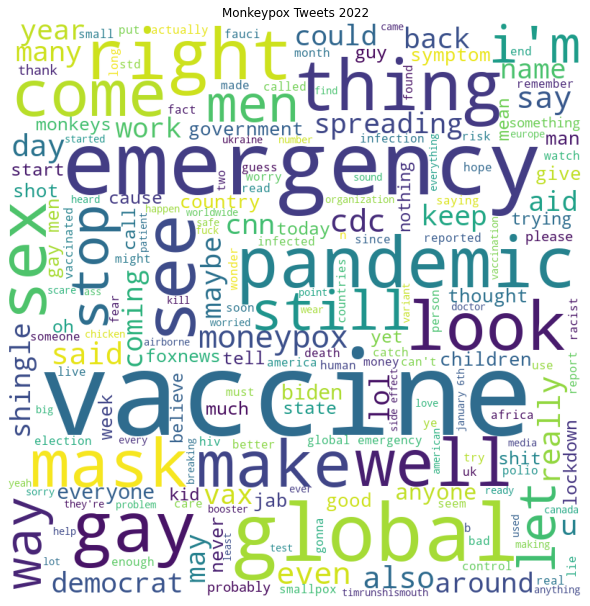

In [240]:
# wordcloud
# https://www.geeksforgeeks.org/generating-word-cloud-python/
comment_words = ''
stopwords = set(stopwords)
 
for val in terms:
    val = str(val)
    tokens = val.split()     
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
     
    comment_words += " ".join(tokens)+" "
 
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words)
 
# plot the WordCloud                       
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.title('Monkeypox Tweets 2022')
plt.savefig("monkeypox-tweets-word-cloud.jpeg");

### 5.3  Case Counts by State

In [ ]:
# import sheet with state lattitude and longitude 
# data source: https://developers.google.com/public-data/docs/canonical/states_csv

# open google spreadsheet
worksheet = gc.open('USA-State-Coordinates').sheet1

# get_all_values gives a list of rows.
rows = worksheet.get_all_values()

states = pd.DataFrame.from_records(rows)

states.columns = states.iloc[0]
states.drop([0], inplace=True)
states.drop(['state'], axis=1, inplace=True)
states.sort_values(by=['name'], inplace=True)
states = states.rename(columns={'latitude': 'lat', 'longitude': 'lon', 'name': 'state'})

states.tail(2)

,lat,lon,state
51,43.78444,-88.787868,Wisconsin
52,43.075968,-107.290284,Wyoming


In [ ]:
states.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52 entries, 1 to 52
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   lat     52 non-null     object
 1   lon     52 non-null     object
 2   state   52 non-null     object
dtypes: object(3)
memory usage: 1.6+ KB


In [ ]:
# import sheet with US case count by state 
# data source: https://www.cdc.gov/poxvirus/monkeypox/response/2022/us-map.html

worksheet = gc.open('2022-US-mpx-cases-by-state').sheet1
rows = worksheet.get_all_values()
cases = pd.DataFrame.from_records(rows)

cases.columns = cases.iloc[0]
cases.drop([0], inplace=True)
cases.drop(['AsOf', 'Case Range'], axis=1, inplace=True)
cases.sort_values(by=['Location'], inplace=True)

cases.tail(2)

,Location,Cases
51,Wisconsin,56
52,Wyoming,1


In [ ]:
# US case count by state (long + lat)
map_data = pd.concat([states, cases], axis=1)
map_data = map_data[['Location', 'Cases', 'lat', 'lon' ]]
map_data = map_data.rename(columns={'Location': 'state', 'Cases':'cases'})

map_data.tail(2)
# map_data.info()

,state,cases,lat,lon
51,Wisconsin,56,43.78444,-88.787868
52,Wyoming,1,43.075968,-107.290284


In [ ]:
map_data = map_data.astype({'cases':'int'})

map_data.sort_values(by=['cases'], ascending=False)
# map_data.sort_values(by=['latitude'], ascending=False)



,state,cases,lat,lon
5,California,3291,36.778261,-119.417932
33,New York,3124,43.299428,-74.217933
10,Florida,1739,27.664827,-81.515754
45,Texas,1472,31.968599,-99.901813
11,Georgia,1299,32.157435,-82.907123
14,Illinois,1005,40.633125,-89.398528
31,New Jersey,479,40.058324,-74.405661
39,Pennsylvania,477,41.203322,-77.194525
21,Maryland,461,39.045755,-76.641271
9,District of Columbia,414,38.905985,-77.033418


In [ ]:
map_data.head(2)

,state,cases,lat,lon
1,Alabama,53,32.318231,-86.902298
2,Alaska,3,63.588753,-154.493062


In [ ]:
map_data.to_csv('map_data.csv')  

# 6 | Deployment

Streamlit App: https://slp22-data-engineering-project-streamlit-mpx-app-ckpzq2.streamlitapp.com/

# 7 | Testing/Robustness

[Python schedule](https://schedule.readthedocs.io/en/stable/examples.html#run-a-job-every-x-minute)